In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [6]:
# Pytorch Tenserboard Support
import torch.utils.data.dataloader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5,))])

#create datasets for training and validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./dataa', train=False, transform=transform, download=True)


#create dataloaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size = 4, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

#Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))


Training set has 60000 instances
Validation set has 10000 instances


As always, let’s visualize the data as a sanity check:

Sneaker Sandal Coat Shirt


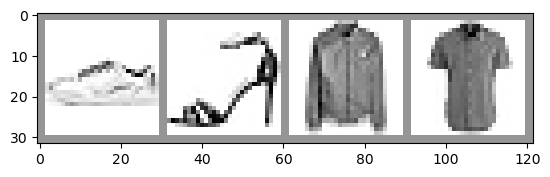

In [12]:
import matplotlib.pyplot as plt
import numpy as np

#Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img= img.mean(dim=0)
    img = img/2+0.5   #unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

detailer = iter(training_loader)
images, labels = next(detailer)

#create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print(' '.join(classes[labels[j]] for j in range(4)))

### The Model

In [21]:
import torch.nn as nn
import torch.nn.functional as F

#Pytorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 *4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = GarmentClassifier()

### Loss Function

In [22]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
#Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])
print(dummy_outputs)
print(dummy_labels)
loss = loss_fn(dummy_outputs, dummy_labels)

print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.2076, 0.6399, 0.8416, 0.2964, 0.1458, 0.1150, 0.9934, 0.8930, 0.7573,
         0.6555],
        [0.8440, 0.9522, 0.5967, 0.2180, 0.0837, 0.1685, 0.8818, 0.3812, 0.4612,
         0.9709],
        [0.6581, 0.0516, 0.0851, 0.0961, 0.2059, 0.0849, 0.0902, 0.4396, 0.9937,
         0.0161],
        [0.2854, 0.4768, 0.7026, 0.7261, 0.5920, 0.7067, 0.3423, 0.1502, 0.1916,
         0.8838]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.5565402507781982


### Optimizer

In [23]:
# Optimization specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### The Training Loop
Below, we have a function that performs one training epoch. It enumerates data from the DataLoader, and on each pass of the loop does the following:

Gets a batch of training data from the DataLoader

Zeros the optimizer’s gradients

Performs an inference - that is, gets predictions from the model for an input batch

Calculates the loss for that set of predictions vs. the labels on the dataset

Calculates the backward gradients over the learning weights

Tells the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose

It reports on the loss for every 1000 batches.

Finally, it reports the average per-batch loss for the last 1000 batches, for comparison with a validation run

In [24]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # Iter(Training_loader) so that we can track the batch
    #Index and do some intra-epoch reporting 

    for i, data in enumerate(training_loader):
        #every data is is an input + label pair
        inputs, labels = data

        #zero your gradients for every batch!
        optimizer.zero_grad()

        #Make predictions for this batch
        outputs = model(inputs)

        #Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        #Adjust learning weights
        optimizer.step()

        #Gather data and report
        running_loss += loss.item()
        if i %1000 == 999:
            last_loss = running_loss/1000 #loss per batch
            print(' batch{} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            running_loss = 0.
    return last_loss


### Per-Epoch Activity
There are a couple of things we’ll want to do once per epoch:

Perform validation by checking our relative loss on a set of data that was not used for training, and report this

Save a copy of the model

Here, we’ll do our reporting in TensorBoard. This will require going to the command line to start TensorBoard, and opening it in another browser tab.

In [25]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestampt = datetime.now().strftime('%y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestampt))
epoch_number = 0
EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}'.format(epoch_number + 1))

    #Make sure gradient tracking is on, and do a pass over the data 
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0

    #set the model to evaluation mode, disabling dropout and using population
    # staistics for batch normalization
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels= vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss/(i + 1)
    print('Loss train {} valid {}'.format(avg_loss, avg_vloss))

    # log the running loss averaged per batch
    # for both training and validation

    writer.add_scalars('Training vs. Validation Loss', 
                       {'Training' : avg_loss, 'Validation' : avg_vloss},
                       epoch_number + 1)
    writer.flush()

    #track best performance and save the model's state 
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestampt, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1
 batch1000 loss: 1.883994389563799
 batch2000 loss: 0.8737245868593454
 batch3000 loss: 0.756003662568517
 batch4000 loss: 0.6781213623033836
 batch5000 loss: 0.6272723501524888
 batch6000 loss: 0.5448964731117012
 batch7000 loss: 0.5549459713848773
 batch8000 loss: 0.5163643680645619
 batch9000 loss: 0.5094751833080955
 batch10000 loss: 0.49104775722988414
 batch11000 loss: 0.4566355167336296
 batch12000 loss: 0.4584247412083205
 batch13000 loss: 0.44875312033167575
 batch14000 loss: 0.42481225799256933
 batch15000 loss: 0.4339544474008726
Loss train 0.4339544474008726 valid 0.430755615234375
EPOCH 2
 batch1000 loss: 0.4170984802845705
 batch2000 loss: 0.4012206527462695
 batch3000 loss: 0.40811170847769246
 batch4000 loss: 0.3954157909740024
 batch5000 loss: 0.3649955371252436
 batch6000 loss: 0.36615988128610477
 batch7000 loss: 0.3743184544081814
 batch8000 loss: 0.3736810132546816
 batch9000 loss: 0.34524442106636705
 batch10000 loss: 0.3668479068452725
 batch11000 loss: 0